In [ ]:

# =========================================================
# OFFLINE GUARD — skip Google Sheets download in this environment
# =========================================================
USE_ONLINE_DOWNLOAD = False  # force offline in this execution environment
def maybe_download_google_sheet(sheet_id: str, dest_path: str) -> bool:
    print("Offline guard active: skipping Google Sheets download here.")
    return False


In [ ]:
# =========================================================
# Options Income Strategy — Full Profitability & Capital Analysis
# Integrated with your download snippet (Google Sheets → Excel via curl)
# - Assignment detection: ONLY the word "assigned" in Comment
# - Side inferred from Type; handles "Put/Call" and "Call/Put" (strike like "A/B")
# - Capital: cash-secured short puts + cash tied in assigned shares (per-lot FIFO segments)
# - Realized P&L (options + stock) by year; annualizes current YTD only
# - Unrealized P&L via Yahoo Finance (yfinance); optionally folded into current year
# - Exports Excel report: options_profitability_report.xlsx
# =========================================================

# ---- Your imports & download code (kept exactly, with a tiny print) ----
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, pathlib, subprocess, shlex, os, re, warnings, io, datetime as dt
warnings.filterwarnings('ignore')

SHEET_ID = "19LhrZai3cbJ1GbPE1iTquYHUeXfpIxXFX1amF5eWi_g"   # <-- paste only the ID string
FILE = 'IBKR_Portfolio_sheets.xlsx'

url = f'https://docs.google.com/spreadsheets/d/{SHEET_ID}/export?format=xlsx'
subprocess.run(shlex.split(f'curl -L -o {FILE} {url}'), check=True)

# --------------------------
# Config
# --------------------------
from dataclasses import dataclass
from typing import List, Dict, Tuple, Optional
from collections import defaultdict
import math

EXCEL_PATH = FILE
SHEETS = ["Options 2024", "Options 2025"]
CONTRACT_MULTIPLIER = 100
AS_OF_DATE: Optional[str] = None   # e.g., "2025-08-16"; None → today
INCLUDE_UNREALIZED_IN_CURRENT_YEAR = True
EXPORT_REPORT_PATH = "options_profitability_report.xlsx"

In [ ]:
# --- Helpers for pretty tables (Corrected Version 2.2) ---
def _format_styler(df, currency_cols=None, pct_cols=None, float_cols=None, int_cols=None):
    """Applies clean, compact formatting to a DataFrame Styler."""
    df_styled = df.copy()
    format_map = {}

    def fmt_pct(v): return f'{v:.1%}' if pd.notna(v) else ''
    def fmt_currency(v): return f'{v:,.0f}' if pd.notna(v) else ''
    def fmt_float(v): return f'{v:,.2f}'.rstrip('0').rstrip('.') if pd.notna(v) else ''
    def fmt_int(v): return f'{v:.0f}' if pd.notna(v) else ''

    if currency_cols is not None:
        for col in currency_cols:
            if col in df_styled.columns: format_map[col] = fmt_currency
    if pct_cols is not None:
        for col in pct_cols:
            if col in df_styled.columns: format_map[col] = fmt_pct
    if float_cols is not None:
        for col in float_cols:
            if col in df_styled.columns: format_map[col] = fmt_float
    if int_cols is not None:
        for col in int_cols:
            if col in df_styled.columns: format_map[col] = fmt_int

    style = df_styled.style.format(format_map, na_rep='-').set_properties(**{'text-align': 'right'})
    style = style.set_table_styles([
        {'selector': 'th', 'props': 'text-align: left; padding-right: 12px;'},
        {'selector': 'td', 'props': 'padding: 4px 8px;'}
    ])

    # **FIX**: The lines that hide the index have been removed to ensure row labels are visible.
    # try:
    #     style = style.hide(axis="index")
    # except Exception:
    #     style = style.hide_index()

    return style

def _safe_cols(df, cols):
    return [c for c in cols if c in df.columns]

In [ ]:
# --------------------------
# Load options (keep raw Type, including Put/Call and Call/Put)
# --------------------------
def load_options() -> pd.DataFrame:
    frames = []
    for sh in SHEETS:
        raw = pd.read_excel(EXCEL_PATH, sheet_name=sh, header=1)
        df = raw.rename(columns={
            "Trans date": "trans_date",
            "Tiker": "ticker",
            "Type": "type",
            "Action": "action",
            "Expiration": "expiration",
            "Strike": "strike",
            "Qty": "qty",
            "Amount": "amount",
            "Comission": "commission",
            "Total P&L": "total_pnl",
            "Comment": "comment",
        })
        for d in ["trans_date","expiration"]:
            df[d] = pd.to_datetime(df[d], errors="coerce").dt.tz_localize(None)
        for n in ["strike","qty","amount","commission","total_pnl"]:
            df[n] = pd.to_numeric(df[n], errors="coerce")
        df["ticker"]  = df["ticker"].astype(str).str.upper().str.strip()
        df["action"]  = df["action"].astype(str).str.title().str.strip()
        df["type"]    = df["type"].astype(str).str.title().str.strip()
        df["comment"] = df["comment"].astype(str)
        df["source_sheet"] = sh
        frames.append(df)
    df_all = pd.concat(frames, ignore_index=True)
    df_all = df_all[df_all["action"].isin(["Sell","Buy"])]
    return df_all

df_opts = load_options()

In [ ]:
# --------------------------
# Lots (short-leg tracking) & assignment detection
# --------------------------
@dataclass
class OptionLot:
    ticker: str
    otype: str   # "Put" or "Call" (the SHORT leg we track)
    strike: float
    qty: float   # contracts
    open_date: pd.Timestamp
    expiration: pd.Timestamp
    premium_net: float  # uses row "Total P&L"
    comment: str
    assigned: bool
    close_date: pd.Timestamp
    close_reason: str   # "expiration" | "closed_early" | "assigned_expiration"

def parse_strike_pair(s: str) -> Tuple[float,float]:
    try:
        a, b = str(s).split("/")
        return float(a), float(b)
    except Exception:
        return math.nan, math.nan

def infer_mixed_short_leg(row: pd.Series) -> Tuple[str, float]:
    """
    For Type 'Put/Call' or 'Call/Put', infer the SHORT leg and its strike.

    Heuristics:
      - If Comment mentions 'short call' or 'long put' -> short call.
      - Else default to short put (typical risk reversal: long call + short put).

    Strikes by order in Type:
      'Put/Call': first = put, second = call
      'Call/Put': first = call, second = put
    """
    t_low = str(row.get("type","")).lower()
    c_low = str(row.get("comment","")).lower()
    a, b = parse_strike_pair(row.get("strike",""))
    put_strike = call_strike = math.nan
    if "put/call" in t_low:
        put_strike, call_strike = a, b
    elif "call/put" in t_low:
        call_strike, put_strike = a, b

    if ("short call" in c_low) or ("long put" in c_low):
        return "Call", call_strike
    else:
        return "Put", put_strike

def build_short_lots_from_rows(df: pd.DataFrame) -> List[OptionLot]:
    lots: List[OptionLot] = []
    rows = df.sort_values(["ticker","trans_date"]).reset_index(drop=True)
    for r in rows.itertuples(index=False):
        t_raw = str(r.type).strip()
        action = r.action
        cmt = r.comment if pd.notna(r.comment) else ""
        # ONLY the word 'assigned' marks assignment (per your rule)
        assigned = ("assigned" in cmt.lower())

        if t_raw in ("Put","Call"):
            if action != "Sell":  # only short single-leg
                continue
            lot = OptionLot(
                ticker=r.ticker,
                otype=t_raw,
                strike=float(r.strike) if pd.notna(r.strike) else math.nan,
                qty=float(r.qty) if pd.notna(r.qty) else 0.0,
                open_date=r.trans_date,
                expiration=r.expiration,
                premium_net=float(r.total_pnl) if pd.notna(r.total_pnl) else 0.0,
                comment=cmt,
                assigned=assigned,
                close_date=r.expiration,
                close_reason="assigned_expiration" if assigned else "expiration",
            )
            lots.append(lot)

        elif ("put/call" in t_raw.lower()) or ("call/put" in t_raw.lower()):
            short_leg, short_strike = infer_mixed_short_leg(r._asdict())
            if pd.isna(short_strike):
                continue
            lot = OptionLot(
                ticker=r.ticker,
                otype=short_leg,
                strike=float(short_strike),
                qty=float(r.qty) if pd.notna(r.qty) else 0.0,
                open_date=r.trans_date,
                expiration=r.expiration,
                premium_net=float(r.total_pnl) if pd.notna(r.total_pnl) else 0.0,
                comment=cmt,
                assigned=assigned,  # 'assigned' applies to the short leg
                close_date=r.expiration,
                close_reason="assigned_expiration" if assigned else "expiration",
            )
            lots.append(lot)
        else:
            continue
    return lots

def apply_buy_to_close_closeouts(lots: List[OptionLot], df: pd.DataFrame) -> None:
    """Match Buy rows to earliest open short (ticker, type, strike, expiration) and close earlier."""
    key_to_indices: Dict[Tuple, List[int]] = defaultdict(list)
    for i, lot in enumerate(lots):
        exp = pd.to_datetime(lot.expiration)
        exp = exp.normalize() if pd.notna(exp) else pd.NaT
        key = (lot.ticker, lot.otype, lot.strike, exp)
        key_to_indices[key].append(i)

    buys = df[(df["action"]=="Buy") & (df["type"].isin(["Put","Call"]))].copy()
    buys = buys.sort_values("trans_date")
    for _, b in buys.iterrows():
        exp = pd.to_datetime(b["expiration"])
        exp = exp.normalize() if pd.notna(exp) else pd.NaT
        key = (str(b["ticker"]).upper().strip(),
               str(b["type"]),
               float(b["strike"]),
               exp)
        indices = key_to_indices.get(key, [])
        if not indices:
            continue
        buy_date = b["trans_date"]
        for idx in indices:
            lot = lots[idx]
            if lot.open_date <= buy_date < lot.close_date:
                lot.close_date = buy_date
                lot.close_reason = "closed_early"
                break

lots = build_short_lots_from_rows(df_opts)
apply_buy_to_close_closeouts(lots, df_opts)

In [ ]:
# --------------------------
# Stock transactions from assigned lots
# --------------------------
@dataclass
class StockTxn:
    date: pd.Timestamp
    ticker: str
    side: str   # "BUY" or "SELL"
    shares: int
    price: float
    source: str # "Assigned"

def stock_txns_from_assigned_lots(lots: List[OptionLot]) -> List[StockTxn]:
    txns: List[StockTxn] = []
    for lot in lots:
        if not lot.assigned:
            continue
        shares = int(round(lot.qty * CONTRACT_MULTIPLIER))
        if shares == 0:
            continue
        if lot.otype == "Put":
            txns.append(StockTxn(lot.close_date.normalize(), lot.ticker, "BUY",  shares, lot.strike, "Assigned"))
        else:  # Call
            txns.append(StockTxn(lot.close_date.normalize(), lot.ticker, "SELL", shares, lot.strike, "Assigned"))
    return txns

stock_txns = stock_txns_from_assigned_lots(lots)

In [ ]:
# --------------------------
# Realized P&L (FIFO) and Ending Inventory
# --------------------------
@dataclass
class RealizedSale:
    date: pd.Timestamp
    ticker: str
    shares: int
    proceeds: float
    cost: float
    pnl: float

@dataclass
class OpenLot:
    ticker: str
    buy_date: pd.Timestamp
    shares_remaining: int
    cost_per_share: float

def compute_stock_realized_and_inventory(txns: List[StockTxn]):
    by_ticker: Dict[str, List[OpenLot]] = defaultdict(list)
    realized: List[RealizedSale] = []
    for t in sorted(txns, key=lambda x: (x.date, x.ticker)):
        if t.side == "BUY":
            by_ticker[t.ticker].append(OpenLot(t.ticker, t.date, t.shares, t.price))
        else:  # SELL
            qty_to_sell = t.shares
            cost_accum = 0.0
            while qty_to_sell > 0 and by_ticker[t.ticker]:
                lot = by_ticker[t.ticker][0]
                take = min(qty_to_sell, lot.shares_remaining)
                cost_accum += take * lot.cost_per_share
                lot.shares_remaining -= take
                qty_to_sell -= take
                if lot.shares_remaining == 0:
                    by_ticker[t.ticker].pop(0)
            proceeds = t.shares * t.price
            cost = cost_accum + (qty_to_sell * t.price if qty_to_sell>0 else 0.0)
            realized.append(RealizedSale(t.date, t.ticker, t.shares, proceeds, cost, proceeds - cost))
    inventory: List[OpenLot] = []
    for tk, lots_list in by_ticker.items():
        for lot in lots_list:
            if lot.shares_remaining > 0:
                inventory.append(lot)
    return realized, inventory

realized_sales, ending_inventory = compute_stock_realized_and_inventory(stock_txns)

In [ ]:
# --------------------------
# Holding segments per BUY lot (accurate capital timeline for shares)
# --------------------------
@dataclass
class HoldSeg:
    ticker: str
    start: pd.Timestamp
    end: pd.Timestamp
    shares: int
    cost_per_share: float

def build_holding_segments(txns: List[StockTxn], as_of: pd.Timestamp) -> List[HoldSeg]:
    """Build per-lot holding segments using FIFO. Each BUY portion sold generates a segment [buy, sell). Unsold → [buy, as_of)."""
    open_buys: Dict[str, List[OpenLot]] = defaultdict(list)
    segs: List[HoldSeg] = []
    for t in sorted(txns, key=lambda x: (x.date, x.ticker)):
        if t.side == "BUY":
            open_buys[t.ticker].append(OpenLot(t.ticker, t.date, t.shares, t.price))
        else:  # SELL
            qty = t.shares
            while qty > 0 and open_buys[t.ticker]:
                lot = open_buys[t.ticker][0]
                used = min(qty, lot.shares_remaining)
                segs.append(HoldSeg(t.ticker, lot.buy_date.normalize(), min(t.date.normalize(), as_of), int(used), lot.cost_per_share))
                lot.shares_remaining -= used
                qty -= used
                if lot.shares_remaining == 0:
                    open_buys[t.ticker].pop(0)
    # Remaining open shares
    for tk, lots_list in open_buys.items():
        for lot in lots_list:
            if lot.shares_remaining > 0:
                segs.append(HoldSeg(tk, lot.buy_date.normalize(), as_of, int(lot.shares_remaining), lot.cost_per_share))
    return segs

In [ ]:
# --------------------------
# Capital timeline (daily)
# --------------------------
def get_as_of_date(df_opts: pd.DataFrame) -> pd.Timestamp:
    return pd.to_datetime(AS_OF_DATE).normalize() if AS_OF_DATE else pd.Timestamp.today().normalize()

as_of_date = get_as_of_date(df_opts)

def daterange_days(start: pd.Timestamp, end: pd.Timestamp) -> pd.DatetimeIndex:
    start = pd.to_datetime(start)
    end = pd.to_datetime(end)
    if pd.isna(start) or pd.isna(end):
        return pd.DatetimeIndex([])
    start = start.normalize()
    end = end.normalize()
    if end <= start:
        end = start + pd.Timedelta(days=1)
    # inclusive start, exclusive end
    return pd.date_range(start, end, freq="D", inclusive="left")

def build_capital_timeline(lots: List[OptionLot], txns: List[StockTxn], as_of: pd.Timestamp) -> pd.DataFrame:
    rows = []
    # Short puts reserve
    for lot in lots:
        if lot.otype == "Put":
            open_d = lot.open_date
            close_d = pd.to_datetime(lot.close_date)
            if pd.isna(close_d):
                close_d = as_of
            else:
                close_d = min(close_d, as_of)
            reserve = lot.strike * CONTRACT_MULTIPLIER * int(round(lot.qty))
            for d in daterange_days(open_d, close_d):
                rows.append((d, "puts_reserve", reserve))
    # Shares invested per holding segment
    segs = build_holding_segments(txns, as_of)
    for seg in segs:
        invested = seg.shares * seg.cost_per_share
        for d in daterange_days(seg.start, seg.end):
            rows.append((d, "shares_invested", invested))
    cap = pd.DataFrame(rows, columns=["date","component","amount"])
    if cap.empty:
        idx = pd.date_range(df_opts["trans_date"].min().normalize(), as_of, freq="D")
        cap = pd.DataFrame({"date": idx, "component": ["puts_reserve"]*len(idx), "amount": [0.0]*len(idx)})
    daily = cap.groupby(["date","component"])["amount"].sum().unstack(fill_value=0.0)
    daily["total"] = daily.sum(axis=1)
    return daily

capital_daily = build_capital_timeline(lots, stock_txns, as_of_date)

In [ ]:

# --------------------------
# Monthly option cycles (standard expiration) & returns
# --------------------------
from pandas.tseries.offsets import WeekOfMonth, MonthBegin


def _third_friday(dt):
    dt = pd.Timestamp(dt)
    return dt.replace(day=1) + WeekOfMonth(week=2, weekday=4)


def _cycle_end(dt):
    dt = pd.Timestamp(dt)
    exp = _third_friday(dt)
    if dt > exp:
        exp = _third_friday(dt + MonthBegin(1))
    return exp


def build_monthly_cycles(df_opts, realized_sales, capital_daily):
    def cyc(d):
        return _cycle_end(d)
    opts = df_opts.copy()
    opts['cycle'] = opts['trans_date'].apply(cyc)
    opts_cycle = opts.groupby('cycle')['total_pnl'].sum().rename('options_pnl_m')
    if realized_sales:
        rs_df = pd.DataFrame({'date':[r.date for r in realized_sales], 'pnl':[r.pnl for r in realized_sales]})
        rs_df['cycle'] = rs_df['date'].apply(cyc)
        stock_cycle = rs_df.groupby('cycle')['pnl'].sum().rename('stock_realized_pnl_m')
    else:
        stock_cycle = pd.Series(dtype=float, name='stock_realized_pnl_m')
    combined = opts_cycle.add(stock_cycle, fill_value=0.0).rename('combined_realized_m')
    cap = capital_daily.copy()
    cap['cycle'] = cap.index.to_series().apply(cyc)
    avg_cap = cap.groupby('cycle')['total'].mean().rename('avg_capital_m')
    monthly = pd.concat([opts_cycle, stock_cycle, combined, avg_cap], axis=1).fillna(0.0)
    monthly['return_m'] = np.where(monthly['avg_capital_m'] > 0,
                                   monthly['combined_realized_m'] / monthly['avg_capital_m'],
                                   np.nan)
    return monthly


monthly = build_monthly_cycles(df_opts, realized_sales, capital_daily)


def twr_annualized_by_year(ret_series):
    grouped = ret_series.groupby(ret_series.index.year)
    return grouped.apply(lambda r: (1 + r).prod() ** (12/len(r)) - 1)


twr_annualized = twr_annualized_by_year(monthly['return_m'].dropna())

In [ ]:
# --------------------------
# Yearly P&L & returns (realized)
# --------------------------
def options_pnl_by_year(df: pd.DataFrame) -> pd.DataFrame:
    tmp = df.copy()
    tmp["year"] = tmp["trans_date"].dt.year
    return tmp.groupby("year")["total_pnl"].sum().rename("options_pnl").reset_index()

def realized_stock_pnl_by_year(realized_sales: List[RealizedSale]) -> pd.DataFrame:
    if not realized_sales:
        return pd.DataFrame(columns=["year","stock_realized_pnl"])
    df = pd.DataFrame([{"date": r.date, "ticker": r.ticker, "shares": r.shares, "pnl": r.pnl} for r in realized_sales])
    df["year"] = df["date"].dt.year
    return df.groupby("year")["pnl"].sum().rename("stock_realized_pnl").reset_index()

def capital_stats_by_year(capital_daily: pd.DataFrame) -> pd.DataFrame:
    df = capital_daily.reset_index()
    df["year"] = df["date"].dt.year
    return df.groupby("year").agg(avg_capital=("total","mean"), peak_capital=("total","max")).reset_index()

def combine_yearly(options_df, realized_df, capital_df, as_of):
    years = sorted(set(capital_df["year"]).union(options_df["year"]).union(realized_df["year"]))
    out = pd.DataFrame({"year": years})
    out = out.merge(options_df, on="year", how="left") \
             .merge(realized_df, on="year", how="left") \
             .merge(capital_df, on="year", how="left")
    out = out.fillna(0.0)
    out["combined_realized"] = out["options_pnl"] + out["stock_realized_pnl"]
    # days elapsed per year from capital timeline
    elapsed_days = (
        capital_daily.reset_index()
        .assign(year=lambda d: d["date"].dt.year)
        .groupby("year")["date"].nunique()
        .rename("days_elapsed").reset_index()
    )
    out = out.merge(elapsed_days, on="year", how="left").fillna({"days_elapsed": 365})
    out["return_on_avg"]  = out["combined_realized"] / out["avg_capital"].replace({0: pd.NA})
    out["return_on_peak"] = out["combined_realized"] / out["peak_capital"].replace({0: pd.NA})
    current_year = as_of.year
    mask_curr = (out["year"] == current_year) & (out["days_elapsed"] < 365)
    factor = 365.0 / out["days_elapsed"]
    out["annualized_return_on_avg"] = out["return_on_avg"]
    out.loc[mask_curr, "annualized_return_on_avg"] = out.loc[mask_curr, "return_on_avg"] * factor[mask_curr]
    out["annualized_return_on_peak"] = out["return_on_peak"]
    out.loc[mask_curr, "annualized_return_on_peak"] = out.loc[mask_curr, "return_on_peak"] * factor[mask_curr]
    return out

opts_year  = options_pnl_by_year(df_opts)
stock_year = realized_stock_pnl_by_year(realized_sales)
cap_year   = capital_stats_by_year(capital_daily)
yearly     = combine_yearly(opts_year, stock_year, cap_year, as_of_date)
yearly = yearly.merge(twr_annualized.rename('annualized_return_twr'), left_on='year', right_index=True, how='left')

In [ ]:
# --------------------------
# Per-ticker realized P&L by year
# --------------------------
def per_ticker_yearly(df_opts: pd.DataFrame, realized_sales: List[RealizedSale]) -> pd.DataFrame:
    o = df_opts.copy()
    o["year"] = o["trans_date"].dt.year
    o_t = o.groupby(["year","ticker"])["total_pnl"].sum().rename("options_pnl").reset_index()
    if realized_sales:
        s = pd.DataFrame([{"date": r.date, "ticker": r.ticker, "pnl": r.pnl} for r in realized_sales])
        s["year"] = s["date"].dt.year
        s_t = s.groupby(["year","ticker"])["pnl"].sum().rename("stock_realized_pnl").reset_index()
    else:
        s_t = pd.DataFrame(columns=["year","ticker","stock_realized_pnl"])
    out = o_t.merge(s_t, on=["year","ticker"], how="outer").fillna(0.0)
    out["combined_realized"] = out["options_pnl"] + out["stock_realized_pnl"]
    return out.sort_values(["year","combined_realized"], ascending=[True, False])

per_ticker = per_ticker_yearly(df_opts, realized_sales)

In [ ]:
# --------------------------
# Yahoo Finance prices (for unrealized P&L)
# --------------------------
def _ensure_yfinance():
    try:
        import yfinance as yf  # noqa
        return yf
    except Exception:
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "yfinance"])
            import yfinance as yf  # noqa
            return yf
        except Exception as e:
            raise RuntimeError("Please install yfinance: pip install yfinance") from e

def fetch_current_prices_yf(tickers) -> Dict[str, float]:
    yf = _ensure_yfinance()
    tickers = sorted({str(t).upper().strip() for t in tickers if isinstance(t, str) and t.strip()})
    prices: Dict[str,float] = {}
    if not tickers:
        return prices

    # Batch attempt
    try:
        data = yf.download(
            tickers=tickers, period="5d", interval="1d",
            auto_adjust=False, progress=False, group_by="ticker", threads=True
        )
        if isinstance(data.columns, pd.MultiIndex):
            for t in tickers:
                series = None
                for col in ("Adj Close", "Close"):
                    try:
                        series = data[(t, col)].dropna()
                        if not series.empty: break
                    except KeyError:
                        continue
                if series is not None and not series.empty:
                    prices[t] = float(series.iloc[-1])
        else:
            # single ticker shape
            series = data["Adj Close"].dropna() if "Adj Close" in data else data["Close"].dropna()
            if not series.empty and len(tickers) == 1:
                prices[tickers[0]] = float(series.iloc[-1])
    except Exception:
        pass

    # Per-ticker fallback
    missing = [t for t in tickers if t not in prices]
    for t in missing:
        try:
            tk = yf.Ticker(t)
            hist = tk.history(period="5d", interval="1d")
            if not hist.empty:
                prices[t] = float(hist["Close"].iloc[-1])
                continue
            try:
                p = getattr(tk.fast_info, "last_price", None)
                if p:
                    prices[t] = float(p)
            except Exception:
                pass
        except Exception:
            pass
    return prices

def unrealized_as_of(inventory: List[OpenLot], prices: Dict[str, float]) -> Tuple[pd.DataFrame, float]:
    rows = []
    total_unreal = 0.0
    for lot in inventory:
        px = prices.get(lot.ticker)
        if px is None or pd.isna(px) or px <= 0:
            continue
        unreal = (px - lot.cost_per_share) * lot.shares_remaining
        rows.append({
            "ticker": lot.ticker,
            "buy_date": lot.buy_date.date(),
            "shares": lot.shares_remaining,
            "cost_per_share": lot.cost_per_share,
            "current_price": px,
            "unrealized_pnl": unreal,
        })
        total_unreal += unreal
    return pd.DataFrame(rows), total_unreal

tickers_to_price = sorted({lot.ticker for lot in ending_inventory})
try:
    live_prices = fetch_current_prices_yf(tickers_to_price)
except Exception as e:
    live_prices = {}

inv_df, total_unreal = unrealized_as_of(ending_inventory, live_prices)

In [ ]:
# Optionally include unrealized in current-year metrics
yearly_with_unreal = yearly.copy()
yearly_with_unreal["combined_incl_unreal"] = yearly_with_unreal["combined_realized"]
yearly_with_unreal["return_on_avg_incl_unreal"]  = yearly_with_unreal["return_on_avg"]
yearly_with_unreal["return_on_peak_incl_unreal"] = yearly_with_unreal["return_on_peak"]
yearly_with_unreal["annualized_return_on_avg_incl_unreal"]  = yearly_with_unreal["annualized_return_on_avg"]
yearly_with_unreal["annualized_return_on_peak_incl_unreal"] = yearly_with_unreal["annualized_return_on_peak"]

if INCLUDE_UNREALIZED_IN_CURRENT_YEAR and total_unreal != 0:
    mask_curr = yearly_with_unreal["year"].eq(as_of_date.year)
    if mask_curr.any():
        yearly_with_unreal.loc[mask_curr, "combined_incl_unreal"] = (
            yearly_with_unreal.loc[mask_curr, "combined_realized"] + total_unreal
        )
        yearly_with_unreal.loc[mask_curr, "return_on_avg_incl_unreal"] = (
            yearly_with_unreal.loc[mask_curr, "combined_incl_unreal"] / yearly_with_unreal.loc[mask_curr, "avg_capital"].replace({0: pd.NA})
        )
        yearly_with_unreal.loc[mask_curr, "return_on_peak_incl_unreal"] = (
            yearly_with_unreal.loc[mask_curr, "combined_incl_unreal"] / yearly_with_unreal.loc[mask_curr, "peak_capital"].replace({0: pd.NA})
        )
        mask = mask_curr & yearly_with_unreal["days_elapsed"].lt(365)
        factor = 365.0 / yearly_with_unreal.loc[mask, "days_elapsed"]
        yearly_with_unreal.loc[mask, "annualized_return_on_avg_incl_unreal"] = yearly_with_unreal.loc[mask, "return_on_avg_incl_unreal"] * factor
        yearly_with_unreal.loc[mask, "annualized_return_on_peak_incl_unreal"] = yearly_with_unreal.loc[mask, "return_on_peak_incl_unreal"] * factor

ERROR:yfinance:$BKR251219P00046000: possibly delisted; no price data found  (period=5d)
ERROR:yfinance:$GOOGL260320C00215000: possibly delisted; no price data found  (period=5d)


## 🏛️ Comprehensive Yearly Performance (Mark-to-Market View)

,Year,Total P&L,Total P&L (incl. Unrealized),Ann. RoAC (w/ Div),Ann. RoAC (incl. Unrealized),Ann. RoPC (w/ Div),Ann. RoPC (incl. Unrealized),Ann. TWR (w/ Div)
0,2024,"8,889",-,14.5%,-,7.1%,-,22.5%
1,2025,"25,809","25,168",18.9%,18.4%,9.9%,9.7%,20.9%


## 📊 Key Performance Metrics (Mark-to-Market Snapshot)

Metric,Value
Cumulative Realized P&L (incl. Dividends),"$34,698"
Current Unrealized P&L (Stocks + Options),$-641
Grand Total P&L (Inception-to-Date),"$34,057"
Peak Capital Deployed,"$285,850"
Return on Peak Capital (Total P&L),11.9%


## 🏛️ Comprehensive Yearly Performance (Realized View)

,Year,Options P&L,Stock P&L,Avg Capital,Peak Capital,Realized P&L (No Div),Days,RoAC (No Div),RoPC (No Div),Ann. RoAC (No Div),Ann. RoPC (No Div),Ann. TWR (No Div),Dividends,Total P&L,RoAC (w/ Div),RoPC (w/ Div),Ann. RoAC (w/ Div),Ann. RoPC (w/ Div),Ann. TWR (w/ Div)
0,2024,"11,949","-3,150","61,234","125,250","8,799",341,14.4%,7.0%,14.4%,7.0%,22.3%,90,"8,889",14.5%,7.1%,14.5%,7.1%,22.5%
1,2025,"23,955","1,600","150,464","285,850","25,555",332,17.0%,8.9%,18.7%,9.8%,20.7%,254,"25,809",17.2%,9.0%,18.9%,9.9%,20.9%


## 📊 Key Performance Metrics (vs. Benchmarks) (Feb '24 - Dec '25)

,CAGR,Volatility,Sharpe Ratio,Sortino Ratio,Max Drawdown
Series,,,,,
My Strategy,21.7%,5.0%,3.18,8.09,-2.4%
Cboe BXM,13.2%,6.9%,1.27,1.7,-9.0%
PUTW ETF,15.0%,9.1%,1.16,1.97,-8.3%
SCHD ETF,7.5%,10.0%,0.38,0.53,-10.1%


## 🎲 Expectancy Analysis

,Category,Count,Win Rate,Avg Win,Avg Loss,Expectancy,Total P&L
0,Options Trades,179,95.5%,221,-234,201,"35,904"
1,Stock Trades,13,53.8%,664,"-2,067",-596,"-1,550"
2,Monthly Cycles,23,95.7%,"1,658","-1,774","1,509","34,698"


## 💰 Per-Ticker P&L Breakdown (Sorted by Realized P&L)

,ticker,Combined Realized 2024,Combined Realized 2025,Options Pnl 2024,Options Pnl 2025,Stock Realized Pnl 2024,Stock Realized Pnl 2025,Total Realized P&L,Total Unrealized P&L,Total Total P&L
0,AAPL,"3,709","1,050","2,709","1,050","1,000",0,"4,758","-1,057","3,701"
1,GOOGL,"3,368","1,150","2,618","1,150",750,0,"4,518","2,895","7,413"
2,WING,0,"3,301",0,"3,301",0,0,"3,301","1,473","4,774"
3,ASAN,"1,691","1,088","2,591","1,088",-900,0,"2,780","-2,012",768
4,RCAT,0,"2,263",0,"2,063",0,200,"2,263","-1,140","1,123"
5,NVDA,222,"2,007",222,"2,007",0,0,"2,229","5,606","7,835"
6,NEM,0,"2,161",0,761,0,"1,400","2,161",0,"2,161"
7,CROX,-197,"2,257","3,803","2,257","-4,000",0,"2,060","-2,349",-289
8,TSEM,0,852,0,852,0,0,852,-68,784
9,IBKR,0,817,0,817,0,0,817,183,"1,000"


## 💰 Per-Ticker P&L Breakdown (Sorted by Total P&L)

,ticker,Combined Realized 2024,Combined Realized 2025,Options Pnl 2024,Options Pnl 2025,Stock Realized Pnl 2024,Stock Realized Pnl 2025,Total Realized P&L,Total Unrealized P&L,Total Total P&L
0,NVDA,222,"2,007",222,"2,007",0,0,"2,229","5,606","7,835"
1,GOOGL,"3,368","1,150","2,618","1,150",750,0,"4,518","2,895","7,413"
2,WING,0,"3,301",0,"3,301",0,0,"3,301","1,473","4,774"
3,AAPL,"3,709","1,050","2,709","1,050","1,000",0,"4,758","-1,057","3,701"
4,NEM,0,"2,161",0,761,0,"1,400","2,161",0,"2,161"
5,RCAT,0,"2,263",0,"2,063",0,200,"2,263","-1,140","1,123"
6,IBKR,0,817,0,817,0,0,817,183,"1,000"
7,GLW,0,684,0,684,0,0,684,276,960
8,TSEM,0,852,0,852,0,0,852,-68,784
9,ASAN,"1,691","1,088","2,591","1,088",-900,0,"2,780","-2,012",768


## 📈 Charts

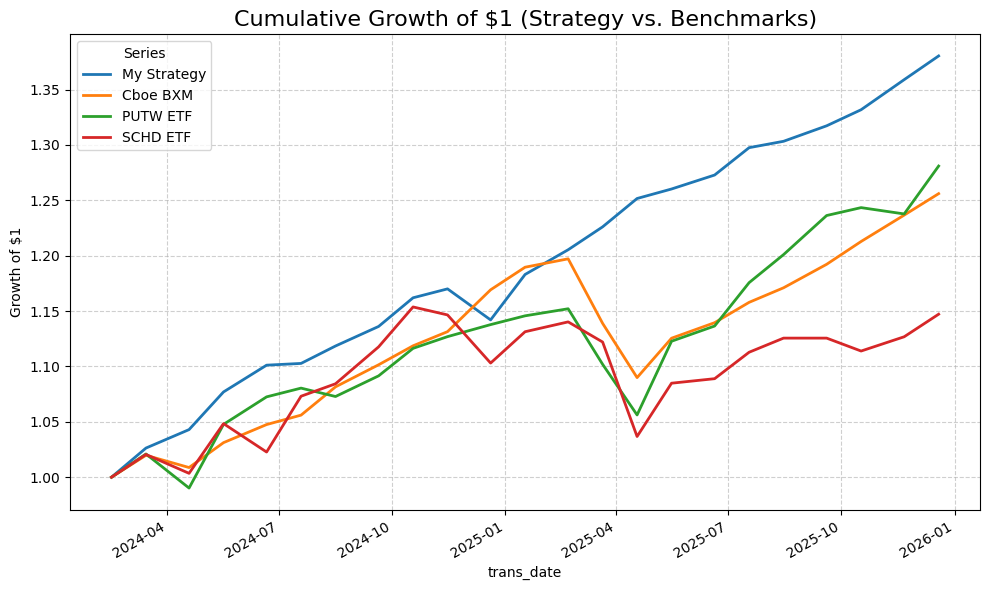

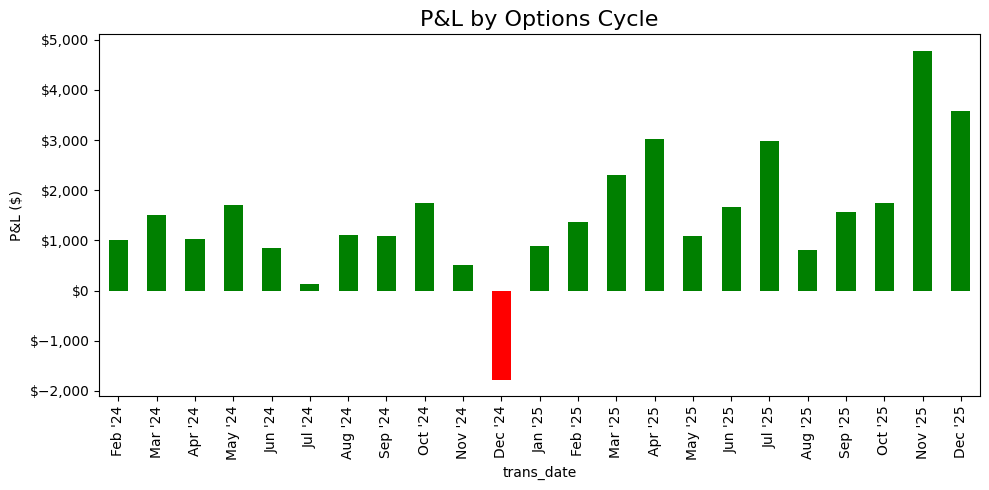

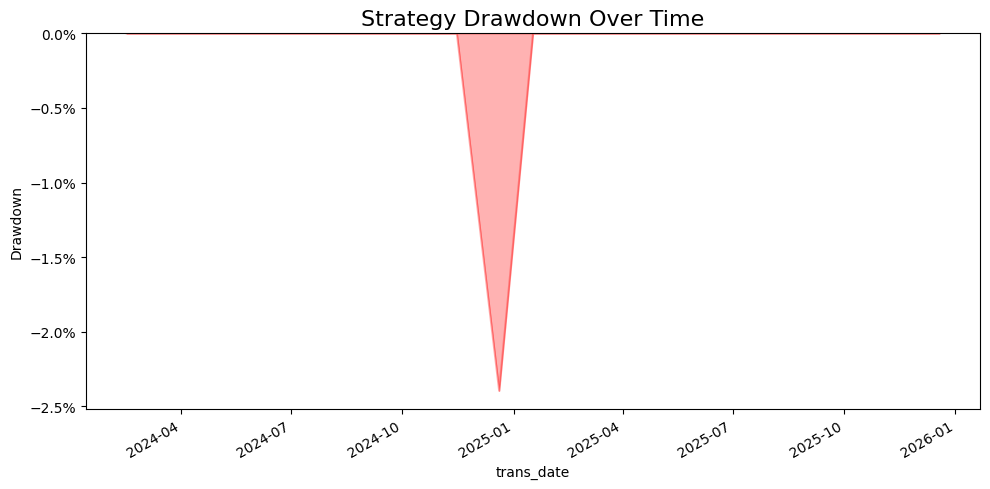

In [ ]:
# ======================================================================
# FINAL CONSOLIDATED PERFORMANCE DASHBOARD (V9.6 - Syntax Fix)
#
# This version includes:
# 1. A mark-to-market (MTM) version of the yearly performance table.
# 2. A snapshot table showing total P&L (realized + unrealized) since inception.
# 3. All original tables and charts for a complete realized and MTM view.
# ======================================================================
from IPython.display import display, Markdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import sys
from pandas.tseries.offsets import WeekOfMonth, MonthBegin
from collections import defaultdict
from dataclasses import dataclass

# =========================================================
# SECTION 1: HELPER & DATA AGGREGATION FUNCTIONS (Copied from original cell)
# =========================================================

def _ensure_yfinance():
    try: import yfinance as yf; return yf
    except ImportError:
        try:
            import subprocess; subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "yfinance"]); import yfinance as yf; return yf
        except Exception as e: print(f"Warning: yfinance could not be installed. Error: {e}"); return None

def _third_friday(dt):
    dt = pd.Timestamp(dt); return dt.replace(day=1) + WeekOfMonth(week=2, weekday=4)

def _cycle_end(dt):
    dt = pd.Timestamp(dt); exp = _third_friday(dt)
    if dt > exp: exp = _third_friday(dt + MonthBegin(1))
    return exp

@dataclass
class DivCash:
    ticker: str; ex_date: pd.Timestamp; per_share: float; shares: int; cash: float

def _get_dividends_for_holdings(stock_txns, as_of_date):
    yf = _ensure_yfinance()
    if not yf: return pd.DataFrame()
    try:
        segments = build_holding_segments(stock_txns, as_of_date)
        if not segments: return pd.DataFrame()
    except Exception: return pd.DataFrame()
    by_ticker = defaultdict(list)
    for s in segments: by_ticker[s.ticker].append((pd.to_datetime(s.start).normalize(), pd.to_datetime(s.end).normalize(), s.shares))
    div_rows = []
    for ticker, seg_list in by_ticker.items():
        try:
            div_hist = yf.Ticker(ticker).dividends
            if div_hist.empty: continue
            div_hist.index = pd.to_datetime(div_hist.index).tz_localize(None).normalize()
            for start, end, shares in seg_list:
                divs_in_period = div_hist[(div_hist.index >= start) & (div_hist.index < end)]
                for ex_date, per_share in divs_in_period.items(): div_rows.append(DivCash(ticker, ex_date, per_share, shares, per_share * shares))
        except Exception: pass
    return pd.DataFrame(div_rows)

def build_monthly_cycles(df_opts, realized_sales, capital_daily, div_df):
    opts_cycle_pnl = df_opts.groupby(df_opts['trans_date'].apply(_cycle_end))['total_pnl'].sum()
    rs_df = pd.DataFrame(realized_sales) if realized_sales else pd.DataFrame(columns=['date', 'pnl'])
    stock_cycle_pnl = rs_df.groupby(rs_df['date'].apply(_cycle_end))['pnl'].sum()
    div_cycle_pnl = div_df.groupby(div_df['ex_date'].apply(_cycle_end))['cash'].sum() if not div_df.empty else pd.Series(dtype=float)
    monthly_df = pd.DataFrame(opts_cycle_pnl).rename(columns={'total_pnl': 'options_pnl_m'})
    monthly_df['stock_realized_pnl_m'] = stock_cycle_pnl; monthly_df['dividends_m'] = div_cycle_pnl; monthly_df = monthly_df.fillna(0)
    monthly_df['combined_realized_m'] = monthly_df['options_pnl_m'] + monthly_df['stock_realized_pnl_m']
    monthly_df['combined_realized_m_w_div'] = monthly_df['combined_realized_m'] + monthly_df['dividends_m']
    capital_daily['cycle'] = capital_daily.index.to_series().apply(_cycle_end)
    avg_cap_m = capital_daily.groupby('cycle')['total'].mean()
    monthly_df['avg_capital_m'] = avg_cap_m.reindex(monthly_df.index).ffill().fillna(0)
    monthly_df['return_m'] = np.where(monthly_df['avg_capital_m'] > 0, monthly_df['combined_realized_m'] / monthly_df['avg_capital_m'], 0.0)
    monthly_df['return_m_w_div'] = np.where(monthly_df['avg_capital_m'] > 0, monthly_df['combined_realized_m_w_div'] / monthly_df['avg_capital_m'], 0.0)
    return monthly_df.sort_index()

def find_open_options(df_opts, as_of_date):
    df_opts_clean = df_opts[pd.to_numeric(df_opts['strike'], errors='coerce').notna()].copy()
    df_opts_clean['trans_date'] = pd.to_datetime(df_opts_clean['trans_date'])
    df_opts_clean['expiration'] = pd.to_datetime(df_opts_clean['expiration'])
    sells = df_opts_clean[df_opts_clean['action'] == 'Sell'].copy()
    buys = df_opts_clean[df_opts_clean['action'] == 'Buy'].copy()
    open_options = []
    for _, sell in sells.iterrows():
        if sell['expiration'] > as_of_date:
            matching_buy = buys[ (buys['ticker'] == sell['ticker']) & (buys['type'] == sell['type']) & (buys['strike'] == sell['strike']) & (buys['expiration'] == sell['expiration']) & (buys['trans_date'] > sell['trans_date']) ]
            if matching_buy.empty:
                open_options.append(sell)
    return pd.DataFrame(open_options)

def fetch_current_option_prices_yf(open_opts_df):
    yf = _ensure_yfinance()
    if not yf or open_opts_df.empty: return {}
    prices = {}
    for _, opt in open_opts_df.iterrows():
        try:
            ticker, exp_str, opt_type, strike_str = opt['ticker'], opt['expiration'].strftime('%y%m%d'), opt['type'][0].upper(), f"{int(opt['strike']*1000):08d}"
            option_symbol = f"{ticker}{exp_str}{opt_type}{strike_str}"
            price = yf.Ticker(option_symbol).fast_info.get('lastPrice')
            if price is not None and price > 0:
                prices[option_symbol] = price
        except Exception: pass
    return prices

def calculate_advanced_unrealized_pnl(ending_inventory, open_options, live_stock_prices, live_option_prices):
    unrealized_rows = []
    # 1. Unrealized P&L from stock
    for lot in ending_inventory:
        current_price = live_stock_prices.get(lot.ticker, 0)
        if current_price > 0:
            pnl = (current_price - lot.cost_per_share) * lot.shares_remaining
            unrealized_rows.append({'ticker': lot.ticker, 'unrealized_pnl': pnl})
    # 2. Unrealized P&L (liability) from open options
    for _, opt in open_options.iterrows():
        if pd.isna(opt['strike']): continue
        ticker, exp_str, opt_type, strike_str = opt['ticker'], opt['expiration'].strftime('%y%m%d'), opt['type'][0].upper(), f"{int(opt['strike']*1000):08d}"
        option_symbol = f"{ticker}{exp_str}{opt_type}{strike_str}"
        current_option_price_per_share = live_option_prices.get(option_symbol, 0)
        if current_option_price_per_share > 0:
            pnl = - (current_option_price_per_share * 100 * opt['qty'])
            unrealized_rows.append({'ticker': opt['ticker'], 'unrealized_pnl': pnl})
    if not unrealized_rows: return pd.Series(dtype=float)
    return pd.DataFrame(unrealized_rows).groupby('ticker')['unrealized_pnl'].sum()

# --- Run Final Data Prep ---
div_df = _get_dividends_for_holdings(stock_txns, as_of_date)
monthly_cycles = build_monthly_cycles(df_opts, realized_sales, capital_daily, div_df)
final_monthly_returns_w_div = monthly_cycles['return_m_w_div'].dropna()
open_options = find_open_options(df_opts, as_of_date)
live_option_prices = fetch_current_option_prices_yf(open_options)
advanced_unrealized_pnl = calculate_advanced_unrealized_pnl(ending_inventory, open_options, live_prices, live_option_prices)


# =========================================================
# SECTION 2: DASHBOARD OUTPUT
# =========================================================

# --- First, prepare the base yearly dataframe used by multiple tables ---
def twr_by_year(ret_series):
    if ret_series.empty: return pd.Series(dtype=float)
    return ret_series.groupby(ret_series.index.year).apply(lambda r: (1 + r).prod() ** (12 / len(r)) - 1 if len(r) > 0 else np.nan)

twr_simple = twr_by_year(monthly_cycles['return_m'].dropna()).rename("annualized_return_twr_simple")
twr_w_div = twr_by_year(final_monthly_returns_w_div).rename("annualized_return_twr_w_div")
dividends_yearly = div_df.groupby(div_df['ex_date'].dt.year)['cash'].sum().rename("dividends_cash")
yearly_summary = yearly.merge(twr_simple, left_on='year', right_index=True, how='left').merge(twr_w_div, left_on='year', right_index=True, how='left')
yearly_summary['dividends_cash'] = dividends_yearly.reindex(yearly_summary['year']).fillna(0).values
yearly_summary['combined_w_div'] = yearly_summary['combined_realized'] + yearly_summary['dividends_cash']
yearly_summary['return_on_avg_w_div'] = yearly_summary['combined_w_div'] / yearly_summary['avg_capital'].replace({0: pd.NA})
yearly_summary['return_on_peak_w_div'] = yearly_summary['combined_w_div'] / yearly_summary['peak_capital'].replace({0: pd.NA})

def annualize_if_current(row, col_name):
    if row['year'] == as_of_date.year and row.get('days_elapsed', 365) < 365: return row[col_name] * (365.0 / row['days_elapsed'])
    return row[col_name]
yearly_summary['annualized_return_on_avg_w_div'] = yearly_summary.apply(lambda r: annualize_if_current(r, 'return_on_avg_w_div'), axis=1)
yearly_summary['annualized_return_on_peak_w_div'] = yearly_summary.apply(lambda r: annualize_if_current(r, 'return_on_peak_w_div'), axis=1)

# Base display table with user-friendly names (used for multiple tables)
rename_dict = { 'year': 'Year', 'options_pnl': 'Options P&L', 'stock_realized_pnl': 'Stock P&L', 'avg_capital': 'Avg Capital', 'peak_capital': 'Peak Capital', 'combined_realized': 'Realized P&L (No Div)', 'days_elapsed': 'Days', 'return_on_avg': 'RoAC (No Div)', 'return_on_peak': 'RoPC (No Div)', 'annualized_return_on_avg': 'Ann. RoAC (No Div)', 'annualized_return_on_peak': 'Ann. RoPC (No Div)', 'annualized_return_twr_simple': 'Ann. TWR (No Div)', 'dividends_cash': 'Dividends', 'combined_w_div': 'Total P&L', 'return_on_avg_w_div': 'RoAC (w/ Div)', 'return_on_peak_w_div': 'RoPC (w/ Div)', 'annualized_return_on_avg_w_div': 'Ann. RoAC (w/ Div)', 'annualized_return_on_peak_w_div': 'Ann. RoPC (w/ Div)', 'annualized_return_twr_w_div': 'Ann. TWR (w/ Div)'}
final_cols = list(rename_dict.keys())
existing_cols = [col for col in final_cols if col in yearly_summary.columns]
yearly_display_base = yearly_summary[existing_cols].rename(columns=rename_dict).sort_values('Year')


# --- NEW TABLE 1: Comprehensive Yearly Performance (Mark-to-Market View) ---
display(Markdown("## 🏛️ Comprehensive Yearly Performance (Mark-to-Market View)"))

# Create a copy for this specific view and calculate total unrealized P&L
yearly_mtm = yearly_display_base.copy()
total_unrealized_pnl = advanced_unrealized_pnl.sum()

# Add new columns, initializing with NaN
yearly_mtm['Total P&L (incl. Unrealized)'] = np.nan
yearly_mtm['Ann. RoAC (incl. Unrealized)'] = np.nan
yearly_mtm['Ann. RoPC (incl. Unrealized)'] = np.nan

# Find the index for the current year to populate data
current_year_idx = yearly_mtm[yearly_mtm['Year'] == as_of_date.year].index
if not current_year_idx.empty:
    idx = current_year_idx[0]
    # Calculate Total P&L (MTM) for the current year
    current_year_realized_pnl = yearly_mtm.loc[idx, 'Total P&L']
    yearly_mtm.loc[idx, 'Total P&L (incl. Unrealized)'] = current_year_realized_pnl + total_unrealized_pnl

    # Get capital and day counts for return calculations
    avg_capital_current = yearly_mtm.loc[idx, 'Avg Capital']
    peak_capital_current = yearly_mtm.loc[idx, 'Peak Capital']
    days_current = yearly_mtm.loc[idx, 'Days']

    # Calculate and annualize MTM returns for the current year
    if avg_capital_current > 0 and days_current > 0:
        roac_mtm = yearly_mtm.loc[idx, 'Total P&L (incl. Unrealized)'] / avg_capital_current
        yearly_mtm.loc[idx, 'Ann. RoAC (incl. Unrealized)'] = roac_mtm * (365.0 / days_current)

    if peak_capital_current > 0 and days_current > 0:
        ropc_mtm = yearly_mtm.loc[idx, 'Total P&L (incl. Unrealized)'] / peak_capital_current
        yearly_mtm.loc[idx, 'Ann. RoPC (incl. Unrealized)'] = ropc_mtm * (365.0 / days_current)

# Select, order, and display the final columns for this table
display_cols_mtm = [
    'Year', 'Total P&L', 'Total P&L (incl. Unrealized)', 'Ann. RoAC (w/ Div)',
    'Ann. RoAC (incl. Unrealized)', 'Ann. RoPC (w/ Div)', 'Ann. RoPC (incl. Unrealized)', 'Ann. TWR (w/ Div)'
]
yearly_mtm_display = yearly_mtm[[col for col in display_cols_mtm if col in yearly_mtm.columns]]
display(_format_styler(
    yearly_mtm_display,
    currency_cols=['Total P&L', 'Total P&L (incl. Unrealized)'],
    pct_cols=[
        'Ann. RoAC (w/ Div)', 'Ann. RoAC (incl. Unrealized)', 'Ann. RoPC (w/ Div)',
        'Ann. RoPC (incl. Unrealized)', 'Ann. TWR (w/ Div)'
    ],
    int_cols=['Year']
))


# --- NEW TABLE 2: Key Performance Metrics (Mark-to-Market Snapshot) ---
display(Markdown("## 📊 Key Performance Metrics (Mark-to-Market Snapshot)"))

# Calculate the summary metrics
cumulative_realized_pnl = yearly_summary['combined_w_div'].sum()
grand_total_pnl = cumulative_realized_pnl + total_unrealized_pnl
peak_capital_deployed = yearly_summary['peak_capital'].max()
return_on_peak_total = grand_total_pnl / peak_capital_deployed if peak_capital_deployed > 0 else 0

# Create the presentation DataFrame
snapshot_df = pd.DataFrame({
    'Metric': [
        'Cumulative Realized P&L (incl. Dividends)',
        'Current Unrealized P&L (Stocks + Options)',
        'Grand Total P&L (Inception-to-Date)',
        'Peak Capital Deployed',
        'Return on Peak Capital (Total P&L)'
    ],
    'Value': [
        cumulative_realized_pnl,
        total_unrealized_pnl,
        grand_total_pnl,
        peak_capital_deployed,
        return_on_peak_total
    ]
})

# Display the snapshot using a simple formatter
display(snapshot_df.style.format({
    'Value': lambda x: f'{x:.1%}' if snapshot_df.loc[snapshot_df['Value'] == x, 'Metric'].iloc[0].startswith('Return') else f'${x:,.0f}'
}).hide(axis="index").set_properties(**{'text-align': 'left'}))


# --- ORIGINAL TABLE 1: Comprehensive Yearly Performance (Realized View) ---
display(Markdown("## 🏛️ Comprehensive Yearly Performance (Realized View)"))
display(_format_styler(yearly_display_base, currency_cols=['Options P&L', 'Stock P&L', 'Avg Capital', 'Peak Capital', 'Realized P&L (No Div)', 'Dividends', 'Total P&L'], pct_cols=['RoAC (No Div)', 'RoPC (No Div)', 'Ann. RoAC (No Div)', 'Ann. RoPC (No Div)', 'Ann. TWR (No Div)', 'RoAC (w/ Div)', 'RoPC (w/ Div)', 'Ann. RoAC (w/ Div)', 'Ann. RoPC (w/ Div)', 'Ann. TWR (w/ Div)'], int_cols=['Year', 'Days']))


# --- ORIGINAL TABLE 2: Key Performance Metrics & Benchmarks (Realized View) ---
def calculate_performance_metrics(ret_series, rf=0.04):
    if ret_series.empty: return {}
    m, ec = len(ret_series), (1 + ret_series).cumprod()
    cagr = ec.iloc[-1] ** (12 / m) - 1 if m > 0 else 0.0; ann_vol = ret_series.std() * np.sqrt(12)
    rf_m = (1 + rf)**(1/12) - 1; excess = ret_series - rf_m
    sharpe = (excess.mean() / ret_series.std()) * np.sqrt(12) if ret_series.std() != 0 else np.nan
    down_std = np.sqrt((excess[excess < 0]**2).sum() / m) if m > 0 else 0
    sortino = (excess.mean() / down_std) * np.sqrt(12) if down_std != 0 else np.nan
    max_dd = (ec / ec.cummax() - 1).min()
    return {"CAGR": cagr, "Volatility": ann_vol, "Sharpe Ratio": sharpe, "Sortino Ratio": sortino, "Max Drawdown": max_dd}

def align_benchmarks_to_cycles_robust(tickers, cycles_df):
    yf = _ensure_yfinance();
    if not yf or cycles_df.empty: return {}
    start, end = cycles_df.index.min() - pd.DateOffset(months=2), cycles_df.index.max() + pd.DateOffset(days=1)
    dates = pd.DataFrame({'end': cycles_df.index, 'start': cycles_df.index.to_series().shift(1).fillna(df_opts['trans_date'].min())})
    all_tickers_list = list(tickers.values())
    try:
        px_data = yf.download(all_tickers_list, start=start, end=end, progress=False, auto_adjust=True)
        if px_data.empty: print("Warning: yfinance returned no data for benchmark tickers."); return {}
        px_data = px_data['Close'] if 'Close' in px_data.columns else px_data
    except Exception as e: print(f"Warning: yfinance download failed. Error: {e}"); return {}
    aligned = {}
    for name, ticker in tickers.items():
        try:
            px = px_data[ticker] if len(all_tickers_list) > 1 else px_data
            px = px.dropna()
            if px.empty: continue
            cycle_returns = [ (px.asof(row['end']) / px.asof(row['start'])) - 1 if pd.notna(px.asof(row['start'])) and pd.notna(px.asof(row['end'])) and px.asof(row['start']) != 0 else np.nan for _, row in dates.iterrows() ]
            aligned[name] = pd.Series(cycle_returns, index=cycles_df.index)
        except Exception as e: print(f"Warning: Could not process benchmark {ticker}. Error: {e}")
    return aligned

strategy_metrics = calculate_performance_metrics(final_monthly_returns_w_div)
strategy_metrics['Series'] = 'My Strategy'
benchmark_tickers = {"Cboe BXM": "^BXM", "PUTW ETF": "PUTW", "SCHD ETF": "SCHD"}
aligned_bench_returns = align_benchmarks_to_cycles_robust(benchmark_tickers, monthly_cycles)
benchmark_metrics = [dict(Series=name, **calculate_performance_metrics(returns)) for name, returns in aligned_bench_returns.items()]
if not final_monthly_returns_w_div.empty:
    # *** SYNTAX FIX APPLIED HERE ***
    start_str = final_monthly_returns_w_div.index.min().strftime('%b \'%y'); end_str = final_monthly_returns_w_div.index.max().strftime('%b \'%y'); period_str = f"({start_str} - {end_str})"
else: period_str = ""
display(Markdown(f"## 📊 Key Performance Metrics (vs. Benchmarks) {period_str}"))
all_metrics_df = pd.DataFrame([strategy_metrics] + benchmark_metrics).set_index('Series')
display(_format_styler(all_metrics_df, pct_cols=['CAGR', 'Volatility', 'Max Drawdown'], float_cols=['Sharpe Ratio', 'Sortino Ratio']))


# --- ORIGINAL TABLE 3: Expectancy Analysis ---
def expectancy_from_series(pnl: pd.Series, name: str):
    s, wins, losses = pnl.dropna(), pnl[pnl > 0], pnl[pnl < 0]
    n, n_wins = len(s), len(wins)
    p_win = n_wins / n if n > 0 else 0
    avg_win, avg_loss = wins.mean(), losses.mean()
    expectancy = (p_win * avg_win) + ((1 - p_win) * avg_loss) if n > 0 else 0
    return {'Category': name, 'Count': n, 'Win Rate': p_win, 'Avg Win': avg_win, 'Avg Loss': avg_loss, 'Expectancy': expectancy, 'Total P&L': s.sum()}
display(Markdown("## 🎲 Expectancy Analysis"))
opt_pnl = df_opts['total_pnl']; stk_pnl = pd.Series([s.pnl for s in realized_sales]) if realized_sales else pd.Series(dtype=float)
expectancy_df = pd.DataFrame([expectancy_from_series(opt_pnl, 'Options Trades'), expectancy_from_series(stk_pnl, 'Stock Trades'), expectancy_from_series(monthly_cycles['combined_realized_m_w_div'], 'Monthly Cycles')]).set_index('Category')
display(_format_styler(expectancy_df.reset_index(), currency_cols=['Avg Win', 'Avg Loss', 'Expectancy', 'Total P&L'], pct_cols=['Win Rate']))


# --- ORIGINAL TABLE 4 & 5: Per-Ticker P&L Breakdowns ---
try:
    per_ticker['year'] = per_ticker['year'].astype(int)
    per_ticker_wide = per_ticker.pivot_table(index='ticker', columns='year', values=['options_pnl', 'stock_realized_pnl', 'combined_realized'], aggfunc='sum', fill_value=0)

    if not per_ticker_wide.empty:
        if 'combined_realized' in per_ticker_wide.columns.get_level_values(0):
            per_ticker_wide[('Total', 'Realized P&L')] = per_ticker_wide['combined_realized'].sum(axis=1)
        else:
            per_ticker_wide[('Total', 'Realized P&L')] = 0

        per_ticker_wide[('Total', 'Unrealized P&L')] = per_ticker_wide.index.map(advanced_unrealized_pnl).fillna(0)
        per_ticker_wide['Total', 'Total P&L'] = per_ticker_wide[('Total', 'Realized P&L')] + per_ticker_wide[('Total', 'Unrealized P&L')]

        # Table sorted by Realized P&L
        display(Markdown("## 💰 Per-Ticker P&L Breakdown (Sorted by Realized P&L)"))
        per_ticker_realized_sorted = per_ticker_wide.sort_values(('Total', 'Realized P&L'), ascending=False)
        display_df_realized = per_ticker_realized_sorted.copy()
        display_df_realized.columns = [" ".join(map(str, col)).replace("_", " ").title() for col in display_df_realized.columns]
        display(_format_styler(display_df_realized.reset_index(), currency_cols=display_df_realized.columns.tolist()))

        # Table sorted by Total P&L
        display(Markdown("## 💰 Per-Ticker P&L Breakdown (Sorted by Total P&L)"))
        per_ticker_total_sorted = per_ticker_wide.sort_values(('Total', 'Total P&L'), ascending=False)
        display_df_total = per_ticker_total_sorted.copy()
        display_df_total.columns = [" ".join(map(str, col)).replace("_", " ").title() for col in display_df_total.columns]
        display(_format_styler(display_df_total.reset_index(), currency_cols=display_df_total.columns.tolist()))
    else:
        display(Markdown("_No ticker data to display._"))
except Exception as e:
    display(Markdown(f"_Could not generate Per-Ticker table. Error: {e}_"))


# --- ORIGINAL CHARTS ---
display(Markdown("## 📈 Charts"))
equity_curves = pd.DataFrame({'My Strategy': (1 + final_monthly_returns_w_div).cumprod()})
for name, returns in aligned_bench_returns.items(): equity_curves[name] = (1 + returns).cumprod()
normalized_curves = equity_curves / equity_curves.iloc[0]
fig, ax = plt.subplots(figsize=(10, 6))
normalized_curves.plot(ax=ax, lw=2)
ax.set_title("Cumulative Growth of $1 (Strategy vs. Benchmarks)", fontsize=16); ax.set_ylabel("Growth of $1"); ax.grid(True, linestyle='--', alpha=0.6); ax.legend(title='Series')
plt.tight_layout(); plt.show()

fig, ax = plt.subplots(figsize=(10, 5))
pnl_series = monthly_cycles['combined_realized_m_w_div']
pnl_series.plot(kind='bar', ax=ax, color=['g' if x >= 0 else 'r' for x in pnl_series])
ax.set_title("P&L by Options Cycle", fontsize=16); ax.set_ylabel("P&L ($)")
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}')); ax.set_xticklabels(pnl_series.index.strftime('%b \'%y'))
plt.tight_layout(); plt.show()

equity_curve = (1 + final_monthly_returns_w_div).cumprod()
drawdown = (equity_curve / equity_curve.cummax() - 1)
fig, ax = plt.subplots(figsize=(10, 5))
drawdown.plot(kind='area', ax=ax, color='red', alpha=0.3)
ax.set_title("Strategy Drawdown Over Time", fontsize=16); ax.set_ylabel("Drawdown")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, 1))
plt.tight_layout(); plt.show()